This notebook takes users through creating the figures for Dynamic World (Figure 2A and Figure 4C)

### Step 1: Import packages

In [1]:
import ee

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

import geopandas as gpd
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.colorbar as cbar
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.image import imread, imsave

### Step 2: Prepare data

This includes splitting the data into calibration and test sets. We use the same seed to maintain repeatability.

In [3]:
SPLIT = 0.5 #50% is used for calibration and remaining 50% is used for evluation
dwl = ee.ImageCollection("projects/ee-geethensingh/assets/UQ/dwTest_probs_4326")

# get the centroids for each image
Features = ee.FeatureCollection(dwl.map(lambda img: ee.Feature(img.geometry()).centroid())).randomColumn(**{'seed': 42})
Features

# Split the centroids
dwCal = Features.filter(ee.Filter.lte('random', SPLIT))#Used to calibrate conformal classifer
dwTest = Features.filter(ee.Filter.gt('random', SPLIT))#Used to evaluate conformal classifier

In [3]:
# Sanity check- visualise the centroids
Map = geemap.Map()
Map.addLayer(ee.Feature(Features.first()))
Map.centerObject(Features.first(), 13)
Map

Map(center=[51.40426473103514, -0.5168443261122376], controls=(WidgetControl(options=['position', 'transparent…

In [4]:
# Convert the centroids to geodataframes
dwCal_gdf = ee.data.computeFeatures({
    'expression': dwCal,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
dwTest_gdf = ee.data.computeFeatures({
    'expression': dwTest,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
dwCal_gdf.crs = 'EPSG:4326'
dwTest_gdf.crs = 'EPSG:4326'
# Add a column called 'Cal' and assign each instance in each of the twos splits a label corresponding to the split they belong.
dwCal_gdf['Cal'] = 'Calibration'
dwTest_gdf['Cal'] = 'Test'

# Combine the resulting geodataframes
import pandas as pd
gdf = pd.concat([dwTest_gdf, dwCal_gdf], ignore_index=True)

### Step 3: Create a map

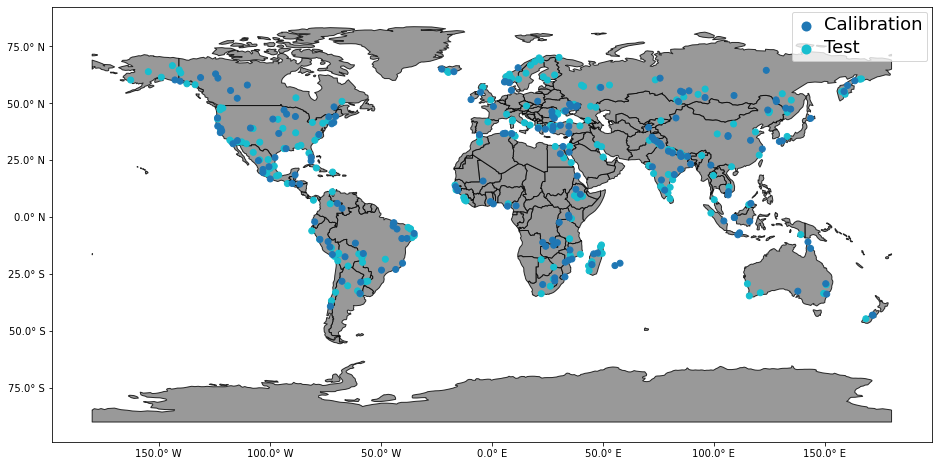

In [6]:
import geopandas as gpd
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# Create a base map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20, 8), alpha=0.8, color='grey', edgecolor='k')

# Assuming you have defined dwCal_gdf and dwTest_gdf GeoDataFrames
gdf.plot(column = 'Cal', ax =ax, legend =True)

# Customize the legend
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))  # Adjust the legend position
for label in legend.get_texts():
    label.set_fontsize(18)  # Set font size for legend labels

# Format the x and y axes with latitude and longitude
def format_lon(value, pos):
    direction = 'N' if value >= 0 else 'S'
    return f'{abs(value)}° {direction}'
def format_lat(value, pos):
    direction = 'E' if value >= 0 else 'W'
    return f'{abs(value)}° {direction}'

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_lat(round(x, 3), _)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_lon(round(y, 3), _)))

# Display the map
# plt.show()

# Save the map to an image file (e.g., PNG)
plt.savefig(r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\DW_sampleDist.png', bbox_inches='tight', pad_inches=0.1, dpi=350, transparent=True)

## Figure 4C: Create a Dynamic World global uncertainty map
### Step 1: Import packages

In [2]:
import ee

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap


### Step 2: Prepare the data

In [6]:
# Load continents shapefile
continents = ee.FeatureCollection("projects/ee-geethensingh/assets/World_Continents")

# Create list of the band of interest - set Length
bandsDW = ee.List(['setLength'])

# Import the image collections for Africa, SAmerica and all remaining areas. Therafter, mosaic
#  the respective imagecollections into a single image
dw = ee.ImageCollection("projects/ee-geethensingh/assets/UQ/DWsetLength").mosaic()
AfricaDW = ee.ImageCollection('users/grazingresearch/for_geethen').mosaic()
SAmericaDW = ee.ImageCollection('users/grazingresearch/for_geethen2').mosaic()

# Create a imagecollection from the three mosaics
dw = ee.ImageCollection.fromImages([dw, AfricaDW, SAmericaDW]).mosaic().clipToCollection(continents)

In [24]:
# Sanity check - Visualise the global set length
Map = geemap.Map()
vis_params = {'bands': ['setLength'], 'palette': ['#440154', ' #440256', ' #450457', ' #450559', ' #46075a', ' #46085c', ' #460a5d', ' #460b5e', ' #470d60', ' #470e61', ' #471063', ' #471164', ' #471365', ' #481467', ' #481668', ' #481769', ' #48186a', ' #481a6c', ' #481b6d', ' #481c6e', ' #481d6f', ' #481f70', ' #482071', ' #482173', ' #482374', ' #482475', ' #482576', ' #482677', ' #482878', ' #482979', ' #472a7a', ' #472c7a', ' #472d7b', ' #472e7c', ' #472f7d', ' #46307e', ' #46327e', ' #46337f', ' #463480', ' #453581', ' #453781', ' #453882', ' #443983', ' #443a83', ' #443b84', ' #433d84', ' #433e85', ' #423f85', ' #424086', ' #424186', ' #414287', ' #414487', ' #404588', ' #404688', ' #3f4788', ' #3f4889', ' #3e4989', ' #3e4a89', ' #3e4c8a', ' #3d4d8a', ' #3d4e8a', ' #3c4f8a', ' #3c508b', ' #3b518b', ' #3b528b', ' #3a538b', ' #3a548c', ' #39558c', ' #39568c', ' #38588c', ' #38598c', ' #375a8c', ' #375b8d', ' #365c8d', ' #365d8d', ' #355e8d', ' #355f8d', ' #34608d', ' #34618d', ' #33628d', ' #33638d', ' #32648e', ' #32658e', ' #31668e', ' #31678e', ' #31688e', ' #30698e', ' #306a8e', ' #2f6b8e', ' #2f6c8e', ' #2e6d8e', ' #2e6e8e', ' #2e6f8e', ' #2d708e', ' #2d718e', ' #2c718e', ' #2c728e', ' #2c738e', ' #2b748e', ' #2b758e', ' #2a768e', ' #2a778e', ' #2a788e', ' #29798e', ' #297a8e', ' #297b8e', ' #287c8e', ' #287d8e', ' #277e8e', ' #277f8e', ' #27808e', ' #26818e', ' #26828e', ' #26828e', ' #25838e', ' #25848e', ' #25858e', ' #24868e', ' #24878e', ' #23888e', ' #23898e', ' #238a8d', ' #228b8d', ' #228c8d', ' #228d8d', ' #218e8d', ' #218f8d', ' #21908d', ' #21918c', ' #20928c', ' #20928c', ' #20938c', ' #1f948c', ' #1f958b', ' #1f968b', ' #1f978b', ' #1f988b', ' #1f998a', ' #1f9a8a', ' #1e9b8a', ' #1e9c89', ' #1e9d89', ' #1f9e89', ' #1f9f88', ' #1fa088', ' #1fa188', ' #1fa187', ' #1fa287', ' #20a386', ' #20a486', ' #21a585', ' #21a685', ' #22a785', ' #22a884', ' #23a983', ' #24aa83', ' #25ab82', ' #25ac82', ' #26ad81', ' #27ad81', ' #28ae80', ' #29af7f', ' #2ab07f', ' #2cb17e', ' #2db27d', ' #2eb37c', ' #2fb47c', ' #31b57b', ' #32b67a', ' #34b679', ' #35b779', ' #37b878', ' #38b977', ' #3aba76', ' #3bbb75', ' #3dbc74', ' #3fbc73', ' #40bd72', ' #42be71', ' #44bf70', ' #46c06f', ' #48c16e', ' #4ac16d', ' #4cc26c', ' #4ec36b', ' #50c46a', ' #52c569', ' #54c568', ' #56c667', ' #58c765', ' #5ac864', ' #5cc863', ' #5ec962', ' #60ca60', ' #63cb5f', ' #65cb5e', ' #67cc5c', ' #69cd5b', ' #6ccd5a', ' #6ece58', ' #70cf57', ' #73d056', ' #75d054', ' #77d153', ' #7ad151', ' #7cd250', ' #7fd34e', ' #81d34d', ' #84d44b', ' #86d549', ' #89d548', ' #8bd646', ' #8ed645', ' #90d743', ' #93d741', ' #95d840', ' #98d83e', ' #9bd93c', ' #9dd93b', ' #a0da39', ' #a2da37', ' #a5db36', ' #a8db34', ' #aadc32', ' #addc30', ' #b0dd2f', ' #b2dd2d', ' #b5de2b', ' #b8de29', ' #bade28', ' #bddf26', ' #c0df25', ' #c2df23', ' #c5e021', ' #c8e020', ' #cae11f', ' #cde11d', ' #d0e11c', ' #d2e21b', ' #d5e21a', ' #d8e219', ' #dae319', ' #dde318', ' #dfe318', ' #e2e418', ' #e5e419', ' #e7e419', ' #eae51a', ' #ece51b', ' #efe51c', ' #f1e51d', ' #f4e61e', ' #f6e620', ' #f8e621', ' #fbe723', ' #fde725'], 'min': 0.0, 'max': 9.0, 'opacity': 1.0}

Map.addLayer(dw, vis_params, 'Dynamic World (uncertainty)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Step 3: Export a png output

In [ ]:
Map.layer_to_image('Dynamic World (uncertainty)', output=r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\DW20km.png', crs='EPSG:3857', region= None, scale=30000)

DW20km.png.tif: |          | 0.00/3.14M (raw) [  0.0%] in 00:00 (eta:     ?)

In [ ]:
# Visualise the exported png
geemap.show_image(r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\DW10km.png')

### Step 4: Create a publication ready figure

In [23]:
# Read the PNG image from disk
image_path = r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\DW10km.png'
image = imread(image_path)

# Plot the image
fig, ax = plt.subplots()
im = ax.imshow(image)
ax.axis('off')  # Turn off the axes

# Add a color bar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust the position and size as needed
norm = Normalize(vmin=1, vmax=9)  # Normalize based on the image values
color_map = cm.viridis  # You can choose a different colormap if needed
cb = cbar.ColorbarBase(cax, cmap=color_map, norm=norm)
cb.set_label('Uncertainty (Set length)', rotation=270, labelpad=15, fontsize=16)  # Add colorbar title
cb.ax.tick_params(labelsize=16)  # Adjust the fontsize of tick labels as needed

# Save the modified image with the color bar
output_path = r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\DW10km.svg'
fig.savefig(output_path, bbox_inches='tight', pad_inches=0.1, dpi = 350)
plt.close()